In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support, classification_report, roc_curve, auc
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score, average_precision_score, f1_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix


%matplotlib inline

**Read and inspect data**

In [2]:
df= pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


0    7963
1    2037
Name: Exited, dtype: int64


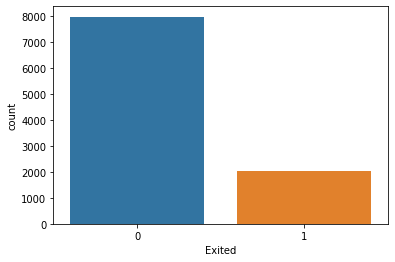

In [3]:
sns.countplot(data=df, x='Exited')
print(df.Exited.value_counts())
## imbalanced data >> consider resampling

In [4]:
x= df.iloc[:,3:13]

In [5]:
x.isna().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

In [6]:
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


**Data cleaning & preprocessing**

In [7]:
x= pd.get_dummies(x,drop_first=True)

In [8]:
x.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [9]:
sc= StandardScaler()

In [10]:
x_scale= sc.fit_transform(x)

# Logistic Regression

**1.Choose feature**

In [11]:
y= df['Exited']

In [12]:
x_scale.shape

(10000, 11)

**2.Split data**

In [13]:
x_train,x_test,y_train,y_test= train_test_split(x_scale,y,test_size= 0.2, random_state=0)

In [14]:
x_train.shape

(8000, 11)

**3.Train model**

In [15]:
model= LogisticRegression(max_iter=200, multi_class= 'ovr')

In [16]:
model.fit(x_train,y_train)

LogisticRegression(max_iter=200, multi_class='ovr')

*interpret the results*

In [17]:
coefficients = np.hstack((model.intercept_, model.coef_[0]))
pd.DataFrame(data={'variable': ['intercept'] + x.columns.to_list() , 'coefficient': coefficients,'exp':np.exp(coefficients)})
# For categorical feature gender, this fitted model says that holding all the other features at fixed values, 
# the odds of churn for males (sex=1) to the odds of churn for females is 0.76. 

,variable,coefficient,exp
0,intercept,-1.636731,0.194615
1,CreditScore,-0.072058,0.930477
2,Age,0.754506,2.126562
3,Tenure,-0.081383,0.921841
4,Balance,0.153207,1.165566
5,NumOfProducts,-0.085291,0.918245
6,HasCrCard,-0.023714,0.976565
7,IsActiveMember,-0.518148,0.595623
8,EstimatedSalary,0.029155,1.029584
9,Geography_Germany,0.358658,1.431407


In [18]:
np.exp(-0.26)

0.7710515858035663

In [19]:
sc.var_.round(0)

array([9.34100000e+03, 1.10000000e+02, 8.00000000e+00, 3.89304683e+09,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.30712604e+09,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

**4.Evaluate model**

***Train dataset - Threshold = 0.5***

*Key metric*

In [20]:
accuracy_score(y_train,model.predict(x_train))

0.8085

In [21]:
precision_score(y_train,model.predict(x_train))

0.5856164383561644

In [22]:
recall_score(y_train,model.predict(x_train))

0.20955882352941177

In [23]:
f1_score(y_train,model.predict(x_train))

0.30866425992779783

In [24]:
roc_auc_score(y_train,model.predict_proba(x_train)[:,1])
#Compute the area under the ROC curve

0.7662073387772194

In [25]:
average_precision_score(y_train,model.predict_proba(x_train)[:,1])

0.4669144928145638

*Confusion matrix*

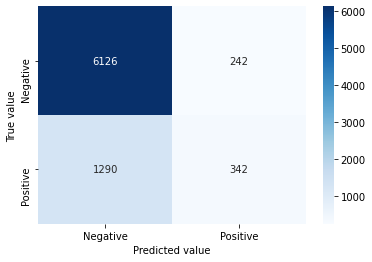

In [26]:
# confusion matrix
cm= pd.DataFrame(confusion_matrix(y_train,model.predict(x_train)), index= ['Negative','Positive'],
                 columns= ['Negative','Positive'])
sns.heatmap(cm,annot=True,fmt='g', cmap='Blues')
plt.ylabel('True value')
plt.xlabel('Predicted value');

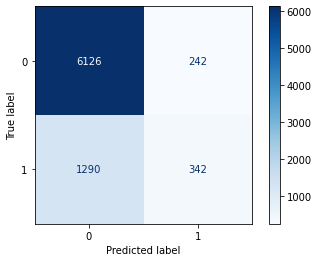

In [27]:
plot_confusion_matrix(model,x_train, y_train,cmap='Blues');

*Report*

In [28]:
# report on train data
print(classification_report(y_train,model.predict(x_train),target_names= ['negative','positive']))
## Model have very low performance on Churned customer (low precision & recall)

              precision    recall  f1-score   support

    negative       0.83      0.96      0.89      6368
    positive       0.59      0.21      0.31      1632

    accuracy                           0.81      8000
   macro avg       0.71      0.59      0.60      8000
weighted avg       0.78      0.81      0.77      8000



In [29]:
# report on test data
print(classification_report(y_test,model.predict(x_test),target_names= ['negative','positive']))

              precision    recall  f1-score   support

    negative       0.83      0.96      0.89      1595
    positive       0.58      0.24      0.34       405

    accuracy                           0.81      2000
   macro avg       0.71      0.60      0.61      2000
weighted avg       0.78      0.81      0.78      2000



In [30]:
# get probability prediction
model.predict_proba(x_train)
# first columns is for class 0, 2nd columns is for class 1

array([[0.82302475, 0.17697525],
       [0.77786634, 0.22213366],
       [0.8009051 , 0.1990949 ],
       ...,
       [0.85387065, 0.14612935],
       [0.91283593, 0.08716407],
       [0.32729897, 0.67270103]])

*ROC Curve*

In [31]:
y_scores= model.predict_proba(x_train)[:,1]
fpr,tpr,thresholds= roc_curve(y_train,y_scores)

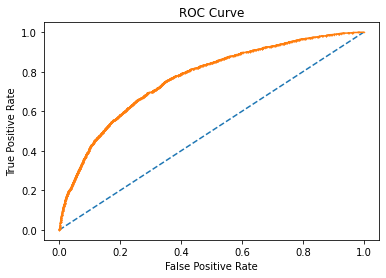

AUC 0.7662073387772194


In [32]:
#ROC plot
plt.plot([0,1],[0,1],linestyle='--')
plt.plot(fpr,tpr,marker='.',markersize=1)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
print("AUC",auc(fpr,tpr))

0.7662073387772194


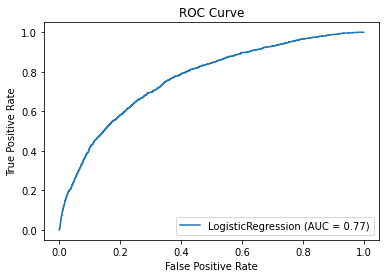

In [33]:
#ROC plot
plot_roc_curve(model, x_train, y_train)
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');
print(roc_auc_score(y_train,y_scores))

*Precision-recall curve*

0.4669144928145638


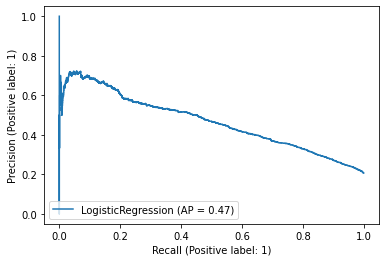

In [34]:
plot_precision_recall_curve(model, x_train,y_train)
print(average_precision_score(y_train,y_scores))

***Examine the result base on probability prediction to see impact of changing threshold***

In [35]:
y_traindf= pd.DataFrame(y_train)
y_traindf.head()

,Exited
7389,0
9275,0
2995,0
5316,0
356,0


In [36]:
y_traindf['Proba']=y_scores
y_traindf.head()

,Exited,Proba
7389,0,0.176975
9275,0,0.222134
2995,0,0.199095
5316,0,0.227049
356,0,0.300575


<AxesSubplot:xlabel='Exited', ylabel='Proba'>

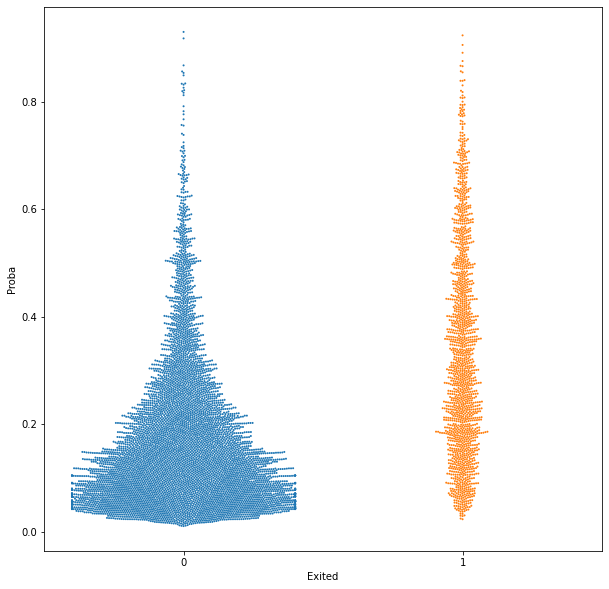

In [37]:
# Visualize 2 classes based on predicted probability to see how the thresholds may impact recall & precision
plt.figure(figsize= (10,10))
sns.swarmplot(data=y_traindf,x='Exited',y='Proba',size=2)
#can use stripplot
# Decrease threshold >> increase recall, at a cost of lower precision 
# Increase threshold >> decrease recall, precision may or may not increase

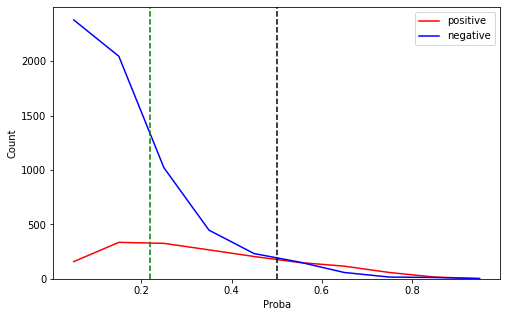

In [38]:
# Visualize 2 classes based on predicted probability to see how the thresholds may impact recall & precision
plt.figure(figsize= (8,5))
sns.histplot(y_traindf.Proba[y_traindf.Exited == 1],label= 'positive',color='r',
             bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],stat='count',element='poly',fill=False)
sns.histplot(y_traindf.Proba[y_traindf.Exited == 0],label= 'negative',color='b',
             bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1],stat='count',element='poly',fill=False)
plt.axvline(x=0.5,linestyle='--',color='black')
plt.axvline(x=0.22,linestyle='--',color='green')
plt.legend();
# increase threshold does not mean 
# decrease thresholds: true positive obtained (red) < false positive obtained (blue) ->> decrease precision
# thresholds> 0.8: true positive obtain(red) < false postive obtain (blue) --> decrease precision


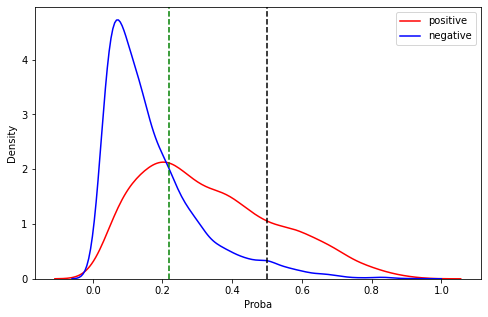

In [39]:
# Visualize 2 classes based on predicted probability to see how the thresholds may impact recall & precision
plt.figure(figsize= (8,5))
sns.kdeplot(y_traindf.Proba[y_traindf.Exited == 1],label= 'positive',color='r')
sns.kdeplot(y_traindf.Proba[y_traindf.Exited == 0],label= 'negative',color='b')
plt.axvline(x=0.5,linestyle='--',color='black')
plt.axvline(x=0.22,linestyle='--',color='green')
plt.legend();

***Evaluate train model threshold***

In [40]:
y_traindf.head()

,Exited,Proba
7389,0,0.176975
9275,0,0.222134
2995,0,0.199095
5316,0,0.227049
356,0,0.300575


In [41]:
# accuracy
for i in np.arange(0,1,0.1):
    print('threshold:' , i.round(1), "accuracy: ", accuracy_score(y_train,y_traindf.Proba>i).round(2))

threshold: 0.0 accuracy:  0.2
threshold: 0.1 accuracy:  0.48
threshold: 0.2 accuracy:  0.7
threshold: 0.3 accuracy:  0.78
threshold: 0.4 accuracy:  0.81
threshold: 0.5 accuracy:  0.81
threshold: 0.6 accuracy:  0.81
threshold: 0.7 accuracy:  0.8
threshold: 0.8 accuracy:  0.8
threshold: 0.9 accuracy:  0.8


In [42]:
# precision
for i in np.arange(0,1,0.1):
    print('threshold: ', i.round(1), '- precision', precision_score(y_train,y_traindf.Proba> i).round(2))

threshold:  0.0 - precision 0.2
threshold:  0.1 - precision 0.27
threshold:  0.2 - precision 0.37
threshold:  0.3 - precision 0.47
threshold:  0.4 - precision 0.54
threshold:  0.5 - precision 0.59
threshold:  0.6 - precision 0.69
threshold:  0.7 - precision 0.72
threshold:  0.8 - precision 0.56
threshold:  0.9 - precision 0.5


In [43]:
# recall
for i in np.arange(0,1,0.1):
    print('threshold: ', i.round(1), '- recall', recall_score(y_train,y_traindf.Proba> i).round(2))
# increase threshold decrease recall

threshold:  0.0 - recall 1.0
threshold:  0.1 - recall 0.9
threshold:  0.2 - recall 0.7
threshold:  0.3 - recall 0.5
threshold:  0.4 - recall 0.34
threshold:  0.5 - recall 0.21
threshold:  0.6 - recall 0.12
threshold:  0.7 - recall 0.05
threshold:  0.8 - recall 0.01
threshold:  0.9 - recall 0.0


In [44]:
# AUC
for i in np.arange(0,1,0.1):
    print('threshold: ', i.round(1), '- AUC', roc_auc_score(y_train,y_traindf.Proba> i).round(2))

threshold:  0.0 - AUC 0.5
threshold:  0.1 - AUC 0.64
threshold:  0.2 - AUC 0.7
threshold:  0.3 - AUC 0.68
threshold:  0.4 - AUC 0.63
threshold:  0.5 - AUC 0.59
threshold:  0.6 - AUC 0.55
threshold:  0.7 - AUC 0.52
threshold:  0.8 - AUC 0.5
threshold:  0.9 - AUC 0.5


# Logistic Regression with Resampling

In [45]:
x_new,y_new= SMOTE(random_state=0).fit_resample(x_train,y_train)

In [46]:
y_new.value_counts()

0    6368
1    6368
Name: Exited, dtype: int64

In [47]:
model_R= LogisticRegression()
model_R.fit(x_new,y_new)

LogisticRegression()

In [48]:
model_R.score(x_new,y_new)

0.7151381909547738

In [49]:
# train data
print(classification_report(y_new,model_R.predict(x_new),target_names= ['negative','positive']))

              precision    recall  f1-score   support

    negative       0.71      0.72      0.72      6368
    positive       0.72      0.71      0.71      6368

    accuracy                           0.72     12736
   macro avg       0.72      0.72      0.72     12736
weighted avg       0.72      0.72      0.72     12736



In [50]:
# test data
print(classification_report(y_test,model_R.predict(x_test),target_names= ['negative','positive']))

              precision    recall  f1-score   support

    negative       0.91      0.70      0.79      1595
    positive       0.38      0.72      0.50       405

    accuracy                           0.70      2000
   macro avg       0.64      0.71      0.64      2000
weighted avg       0.80      0.70      0.73      2000

